# Survival analysis

- censoring
    - right/left/interval censoring

## Elements of survival analysis
- **Survivor Function**: The survivor function, $S(t)$, describes the probability that an individual or subject will survive beyond a given time $t$. It is a decreasing function that starts at 1 (100% survival at time zero) and decreases as time progresses: $S(t) = P(T \geq t) = 1-F(t)$, where F(t) is cumulative distribution function.
- **Hazard Function**: The hazard function, $h(t)$, represents the instantaneous rate at which events occur at time $t$, given that the subject has survived up until time $t$. It describes the risk of the event happening in the next instant, conditional on survival until that time.

## TODO
- https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Feature-Selection:-Which-Variable-is-Most-Predictive?

In [131]:
from conscious_engie_icare.scania import preprocessing, dataset, util
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sksurv.linear_model import CoxPHSurvivalAnalysis
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Load data.

In [2]:
df_ts = dataset.load_ts(add_labels=True)
df_repair = dataset.load_repairs()
df_ts.head()

100% 1122452/1122452 [00:11<00:00, 94724.60it/s] 


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35,delta_time,class
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0,498.8,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0,498.6,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0,490.4,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,2522.0,12.0,1444.0,211688.0,318901.0,107745.0,19406.0,453.0,489.8,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,2562.0,12.0,1445.0,213956.0,323997.0,109514.0,19535.0,454.0,489.0,0


Preprocessing:

In [83]:
df_ts_preprocessed = preprocessing.interpolate_ts(df_ts)
df_ts_preprocessed = preprocessing.remove_empty_rows(df_ts_preprocessed)
list_of_attribute_columns = dataset.extract_list_of_attribute_columns(df_ts_preprocessed)
list_of_sensor_bins = util.merge_lists_with_one_element(list_of_attribute_columns)
# ATTENTION: IF THE SUM IS 0, THEN THE VALUE IS NAN. IN THIS CASE, WE CAN GIVE THE HISTOGRAM A UNIFORM DISTRIBUTION OR REMOVE THE VALUES!
df_ts_preprocessed, _ = preprocessing.normalize_by_total_count(df_ts_preprocessed, list_of_sensor_bins, correct_histograms=True)

Removing 1217 rows with missing values.
sum < 1 for sensor bins ['291_0', '291_1', '291_2', '291_3', '291_4', '291_5', '291_6', '291_7', '291_8', '291_9', '291_10'] in 4015 rows. Those will be replaced with a uniform distibution!


Convert into X, y format:

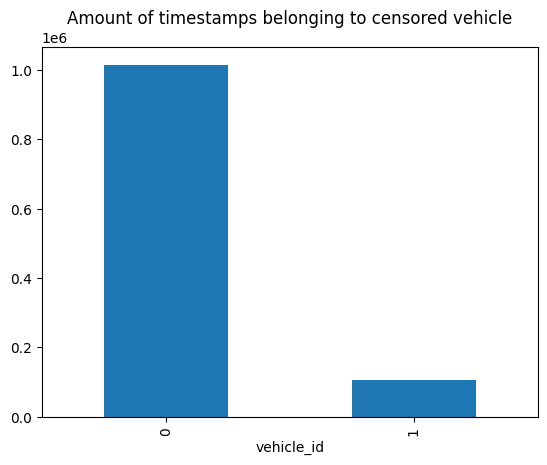

In [84]:
# Example data shapes:
# X: (1200000, 105) - Feature matrix
# y: (1200000,) - Time-to-event data
# c: (1200000,) - Censoring indicator (0 for censored, 1 for event observed)
X = df_ts_preprocessed[dataset.ATTRIBUTE_COLUMNS].to_numpy()
delta_time = df_ts_preprocessed['delta_time']

# censored vehicles
was_repaired = df_repair.set_index('vehicle_id')['in_study_repair'].to_dict()
was_repaired = {str(k): v for k, v in was_repaired.items()}
c = df_ts_preprocessed['vehicle_id'].map(was_repaired)

# visualize censored vehicles
ax = c.value_counts().plot.bar()
ax.set_title('Amount of timestamps belonging to censored vehicle');

# Convert y and c into a structured array suitable for survival analysis
y = np.array([(censoring == 1, time) for censoring, time in zip(c, delta_time)],
               dtype=[('event', '?'), ('time', '<f8')])

Train-test split:

In [85]:
# Data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train

array([(False, 124.2), (False,  45.8), (False,  22.4), ...,
       (False, 136.6), (False,  55.8), (False, 410.8)],
      dtype=[('event', '?'), ('time', '<f8')])

# Linear models

## Cox proportional hazards model (CoxPHSurvivalAnalysis)

The Cox Proportional Hazards model is a survival analysis method that models the hazard function $h(t \mid \mathbf{x})$ for an individual with covariates $\mathbf{x} = (x_1, x_2, \dots, x_p)$ at time $t$ as:


$h(t \mid \mathbf{x}) = h_0(t) \cdot \exp(\mathbf{\beta}^\top \mathbf{x})$

Here, $h_0(t)$ is the baseline hazard function, which is unspecified and common to all individuals. It characterizes how the hazard functions changes as a function of survival time. The vector $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$ represents the coefficients for the covariates, and $\exp(\mathbf{\beta}^\top \mathbf{x})$ is the risk score, determining how the covariates modify the hazard. The key assumption of the model is that the hazard ratio between two individuals is constant over time, meaning the ratio of their hazards is independent of time:

$\frac{h(t \mid \mathbf{x}_1)}{h(t \mid \mathbf{x}_2)} = \exp\left(\mathbf{\beta}^\top (\mathbf{x}_1 - \mathbf{x}_2)\right)$

This makes the model semi-parametric, as it does not require explicit specification of $h_0(t)$.

<div style="border: 1px solid #ccc; border-radius: 5px; padding: 10px; margin: 10px 0;">
    <details class="details-box">
        <summary style="cursor: pointer; font-weight: bold;">Click to toggle more details on why the model is semi-parametric</summary>
        <p style="margin-top: 10px;">
            A semi-parametric model is a type of statistical model that combines elements of both parametric and non-parametric models. In a semi-parametric model:

- **Parametric Component**: The model includes a part where the form of the relationship between variables is specified and involves a finite number of parameters. For example, in the Cox Proportional Hazards model, the parametric component is the linear predictor $\mathbf{\beta}^\top \mathbf{x}$, where $\mathbf{\beta}$ are the parameters that need to be estimated.

- **Non-parametric Component**: Another part of the model does not assume a specific parametric form and can vary more freely. In the Cox model, the baseline hazard function $h_0(t)$ is non-parametric because it is not specified by a particular functional form and is instead estimated from the data.

This blend allows semi-parametric models to be more flexible than fully parametric models while still retaining some structure, making them useful in situations where you want to model certain aspects parametrically but leave other aspects unspecified or data-driven.
        </p>
    </details>
</div>

### Assumtions of CoxPH
- observations are independent
- harards are proportional: the effect of the covariates on the hazard is multiplicative and constant over time. This means that the hazard ratios between individuals are constant across time; the relationship between covariates and the hazard does not change as time progresses.

### Estimate coefficients $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$
Minimizing the negative partial log-likelihood ensures that the estimated coefficients for the covariates best explain the observed relationship between the covariates and the hazard of the event occurring, according to the CoxPH model.

### Notes
Survival analysis (on raw features) --> ill-conditioned

In [86]:
start_time = time.time()
samples = np.random.choice(len(X_train), size=500000, replace=False)
X_train_sample = X_train #[samples]
y_train_sample = y_train #[samples]
cox_model = CoxPHSurvivalAnalysis()
# Minimize negative partial log-likelihood for provided data
cox_model.fit(X_train_sample, y_train_sample)
end_time = time.time()
print(f'elapsed time: {round(end_time - start_time, 2)} seconds')

/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.10034e-17): result may not be accurate.
  delta = solve(
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.33627e-17): result may not be accurate.
  delta = solve(
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=8.66178e-17): result may not be accurate.
  delta = solve(
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.29334e-17): result may not be accurate.
  delta = solve(
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.41322e-17): result may not be accurate.
  delta = solve(
/root/miniconda3/env

elapsed time: 252.46 seconds


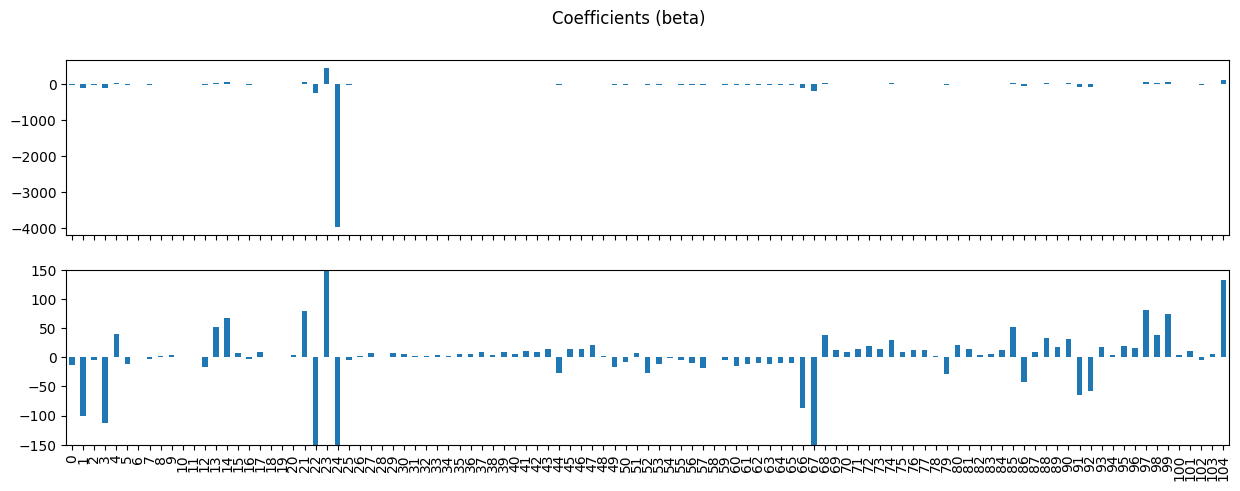

In [109]:
fig, axes = plt.subplots(figsize=(15, 5), nrows=2, sharex=True)
ax = pd.Series(cox_model.coef_).plot.bar(ax=axes[0])
ax = pd.Series(cox_model.coef_).plot.bar(ax=axes[1])
ax.set_ylim(-150, 150);
fig.suptitle('Coefficients (beta)');

## Evaluate model

### Survival metrics

...

#### Concordance index (c-index)
The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic).
It is a measure of **rank correlation between predicted risk scores and observed time points** that is closely related to Kendall’s $\tau$.

- a value of 0.5 denotes a random model
- a value of 1.0 denotes a perfect model
- a value of 0.0 denotes a perfectly wrong model.

### Anomaly metrics 

Convert into an anomaly detection problem.

- ROC curve / AUC
- Accuracy
- F1 score

In [111]:
from sksurv.metrics import concordance_index_censored

start_time = time.time()
samples = np.random.choice(len(X_test), size=100000, replace=False)
X_test_sample = X_test  # X_test[samples]
y_test_sample = y_test  # y_test[samples]

# Predict the risk scores on the test set
risk_scores = cox_model.predict(X_test_sample)

# Calculate the concordance index
c_index = concordance_index_censored(y_test_sample["event"], y_test_sample["time"], risk_scores)[0]
print(f"Concordance Index: {c_index:.4f}")
end_time = time.time()
print(f'elapsed time: {round(end_time - start_time, 2)} seconds')

Concordance Index: 0.7023
elapsed time: 15.75 seconds


The `risk_score` expresses the relative risk of an event occurring for each individual in the test set, based on their covariates.

The risk scores obtained from `risk_scores = cox_model.predict(X_test_sample)` in the Cox Proportional Hazards (CoxPH) model represent the relative risk of an event occurring for each individual in the test set, based on their covariates.
Mathematically, the risk score for an individual $i$ with covariates $\mathbf{x}_i$ is:
$\text{Risk Score}_i = \exp(\mathbf{\beta}^\top \mathbf{x}_i)$
where $\mathbf{\beta}$ are the coefficients estimated by the Cox model.

**Interpretation**:
- **High Risk Scores**: Individuals with higher risk scores have a higher relative risk of experiencing the event sooner compared to others with lower risk scores. This means they are more likely to have the event happen earlier.
- **Low Risk Scores**: Conversely, individuals with lower risk scores have a lower relative risk, meaning they are expected to survive longer without experiencing the event, relative to those with higher risk scores.

**No Absolute Prediction**: The CoxPH model does not provide a direct prediction of the exact time until the event occurs. Instead, it ranks individuals by their risk of the event, allowing you to determine which individuals are at higher or lower risk relative to each other.

**Comparative Analysis**: The risk scores can be used to compare different individuals or groups. For example, you might compare the risk scores of individuals with different covariate profiles to see which group is at higher risk of the event.

count    224247.000000
mean         12.789118
std           0.897370
min         -25.517728
25%          12.379539
50%          12.897447
75%          13.316932
max          18.708002
dtype: float64

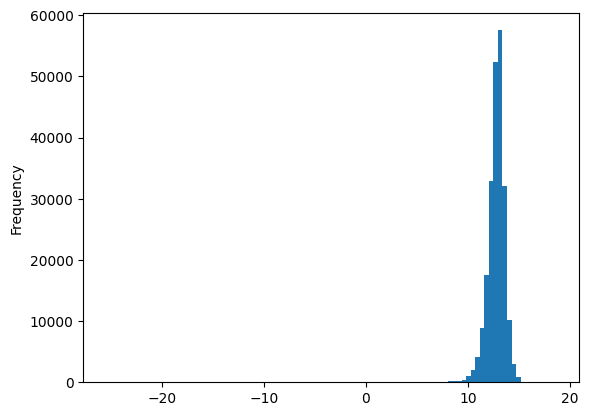

In [112]:
display(pd.Series(risk_scores).describe())
ax = pd.Series(risk_scores).plot.hist(bins=100)

Predict survival function.

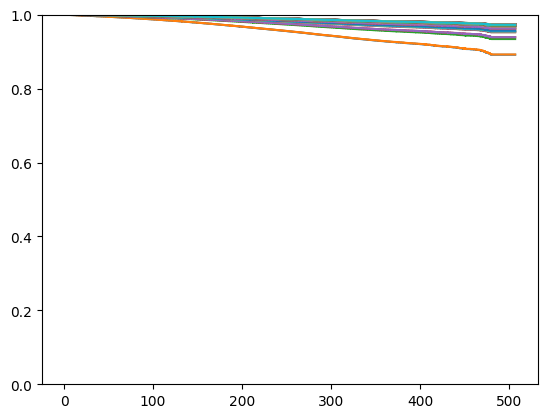

In [119]:
surv_funcs = cox_model.predict_survival_function(X[:100])

for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

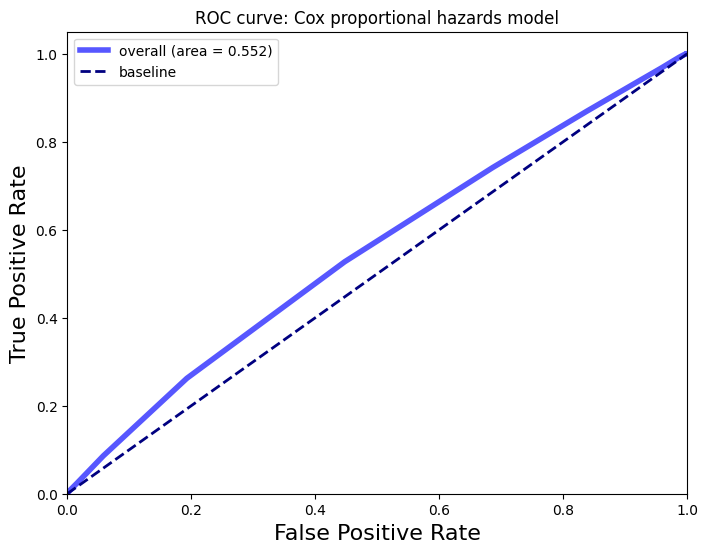

In [149]:
import sklearn.metrics as skmetrics

def calculate_roc_characteristics(distance_vector, anomaly_vector, verbose=False, exact=True):
    
    
    sorted_index_array = np.argsort(distance_vector)

    # Initialize variables to store ROC curve values
    fpr = []
    tpr = []

    if exact: 
        thresholds = distance_vector[sorted_index_array]
    else: 
        min_ = distance_vector[sorted_index_array].min()
        max_ = distance_vector[sorted_index_array].max()
        thresholds = np.arange(min_, max_, (max_ - min_) / 100)
    for threshold in tqdm(thresholds, disable=(not verbose)):
        predicted_anomaly = distance_vector >= threshold

        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        true_positives = ((anomaly_vector == 1) & (predicted_anomaly == 1)).sum()
        false_positives = ((anomaly_vector == 0) & (predicted_anomaly == 1)).sum()
        true_negatives = ((anomaly_vector == 0) & (predicted_anomaly == 0)).sum()
        false_negatives = ((anomaly_vector == 1) & (predicted_anomaly == 0)).sum()

        tpr.append(true_positives / (true_positives + false_negatives))
        fpr.append(false_positives / (false_positives + true_negatives))

    # Calculate the area under the ROC curve (AUC)
    roc_auc = skmetrics.auc(fpr, tpr)

    return fpr, tpr, roc_auc


def plot_roc(fpr, tpr, roc_auc=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    label = f'overall (area = {roc_auc:.3f})' if roc_auc is not None else ''
    ax.plot(fpr, tpr, color='blue', lw=4, label=label, alpha=0.66)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.05)
    ax.set_title('ROC curve', size=24)
    ax.set_xlabel('False Positive Rate', size=16)
    ax.set_ylabel('True Positive Rate', size=16)
    ax.legend()
    return fig, ax

anomaly_vector = y_test_sample['time'] < 48
fpr, tpr, roc_auc = calculate_roc_characteristics(risk_scores, anomaly_vector, verbose=True, exact=False)
fig, ax = plot_roc(fpr, tpr, roc_auc=roc_auc)
ax.set_title('ROC curve: Cox proportional hazards model');